In [0]:
!pip3 install --quiet sentencepiece
import tensorflow as tf
import tensorflow_hub as hub
import sentencepiece as spm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns

In [0]:
module = hub.Module("https://tfhub.dev/google/universal-sentence-encoder-lite/2")

In [0]:
input_placeholder = tf.sparse_placeholder(tf.int64, shape=[None, None])
encodings = module(
    inputs=dict(
        values=input_placeholder.values,
        indices=input_placeholder.indices,
        dense_shape=input_placeholder.dense_shape))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:11:19.925288 139959359092608 saver.py:1483] Saver not created because there are no variables in the graph to restore


In [0]:
with tf.Session() as sess:
  spm_path = sess.run(module(signature="spm_path"))

sp = spm.SentencePieceProcessor()
sp.Load(spm_path)
print("SentencePiece model loaded at {}.".format(spm_path))

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0330 19:11:22.995079 139959359092608 saver.py:1483] Saver not created because there are no variables in the graph to restore


SentencePiece model loaded at b'/tmp/tfhub_modules/539544f0a997d91c327c23285ea00c37588d92cc/assets/universal_encoder_8k_spm.model'.


In [0]:
def process_to_IDs_in_sparse_format(sp, sentences):
  # An utility method that processes sentences with the sentence piece processor
  # 'sp' and returns the results in tf.SparseTensor-similar format:
  # (values, indices, dense_shape)
  ids = [sp.EncodeAsIds(x) for x in sentences]
  max_len = max(len(x) for x in ids)
  dense_shape=(len(ids), max_len)
  values=[item for sublist in ids for item in sublist]
  indices=[[row,col] for row in range(len(ids)) for col in range(len(ids[row]))]
  return (values, indices, dense_shape)

In [0]:
# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

values, indices, dense_shape = process_to_IDs_in_sparse_format(sp, messages)

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(
      encodings,
      feed_dict={input_placeholder.values: values,
                input_placeholder.indices: indices,
                input_placeholder.dense_shape: dense_shape})

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

Message: Elephant
Embedding size: 512
Embedding: [0.053387489169836044, 0.05319438502192497, -0.052356038242578506, ...]

Message: I am a sentence for which I would like to get its embedding.
Embedding size: 512
Embedding: [0.035332921892404556, -0.04714974761009216, 0.012305514886975288, ...]

Message: Universal Sentence Encoder embeddings also support short paragraphs. There is no hard limit on how long the paragraph is. Roughly, the longer the more 'diluted' the embedding will be.
Embedding size: 512
Embedding: [-0.004081644117832184, -0.08954869955778122, 0.03737198933959007, ...]



In [0]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import keras
from sklearn.model_selection import train_test_split
from keras.layers import Input,Lambda,Dense,Dropout
from keras.models import Model
import keras.backend as K
#data loading 
fake = pd.read_csv("gossipcop_fake.csv")
real = pd.read_csv("gossipcop_real.csv")
fake_t = fake.title.values
real_t = real.title.values
X = np.concatenate([fake_t,real_t],axis=0)
fake["label"] = 0
real["label"] = 1
fake_l = fake.label.values
real_l = real.label.values
Y = np.concatenate([fake_l,real_l],axis=0)

In [0]:
X.shape

(22140,)

In [0]:
for i in range(1000,20000,1000): 
  y = X[i-1000:i+1]
  values, indices, dense_shape = process_to_IDs_in_sparse_format(sp,y)
  with tf.Session() as session:
    session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    message_embeddings = session.run(
        encodings,
        feed_dict={input_placeholder.values: values,
                  input_placeholder.indices: indices,
                  input_placeholder.dense_shape: dense_shape})
  #tf.reset_default_graph()
  if(i==1000):
    p = message_embeddings
  else:
    p = np.append(p,message_embeddings,axis=0)

In [0]:
p = np.append(p,message_embeddings)

In [0]:
p = message_embeddings

In [0]:
p = np.append(p,p,axis=0)

In [0]:
p.shape

(19019, 512)

In [0]:
np.savetxt('test.out', p, delimiter=',')

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping,ModelCheckpoint
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(512,)))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 257       
Total params: 197,377
Trainable params: 197,377
Non-trainable params: 0
_________________________________________________________________


In [0]:
batch_size = 128
#num_classes = 10
epochs = 200

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
Y_n = Y[:19019]
Y_n.shape


(19019,)

In [0]:
history = model.fit(p, Y_n,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.2,callbacks=[es,mc])

Train on 15215 samples, validate on 3804 samples
Epoch 1/200
15215/15215 [==============================] - 3s 204us/step - loss: 0.5216 - acc: 0.7422 - val_loss: 0.3564 - val_acc: 0.8578

Epoch 00001: val_acc improved from -inf to 0.85778, saving model to best_model.h5
Epoch 2/200
15215/15215 [==============================] - 1s 44us/step - loss: 0.4761 - acc: 0.7731 - val_loss: 0.2643 - val_acc: 0.9227

Epoch 00002: val_acc improved from 0.85778 to 0.92271, saving model to best_model.h5
Epoch 3/200
15215/15215 [==============================] - 1s 44us/step - loss: 0.4522 - acc: 0.7940 - val_loss: 0.3134 - val_acc: 0.8835

Epoch 00003: val_acc did not improve from 0.92271
Epoch 4/200
15215/15215 [==============================] - 1s 43us/step - loss: 0.4336 - acc: 0.7993 - val_loss: 0.3232 - val_acc: 0.8754

Epoch 00004: val_acc did not improve from 0.92271
Epoch 5/200
15215/15215 [==============================] - 1s 44us/step - loss: 0.4098 - acc: 0.8154 - val_loss: 0.3050 - val_a

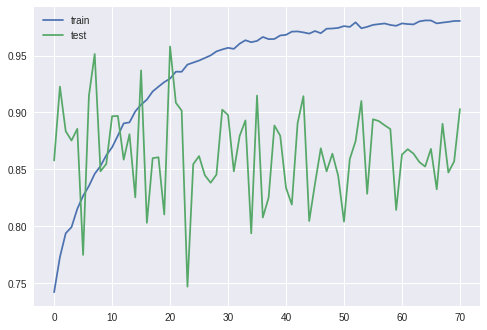

In [0]:
from matplotlib import pyplot
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.legend()
pyplot.show()